In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob, os, random
from tabulate import tabulate
from sklearn.model_selection import KFold
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from keras import applications
import gc
import tensorflow as tf
from skimage import data, io, filters
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

In [3]:
gc.collect()

146

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
base_path  = '/content/drive/MyDrive/Awareness of Waste Recycling'

classes = os.listdir(base_path)
print(classes)

['metal', 'e-waste', 'glass', 'plastic', 'light blubs', 'batteries', 'organic', 'clothes', 'paper', 'classifyWaste.h5']


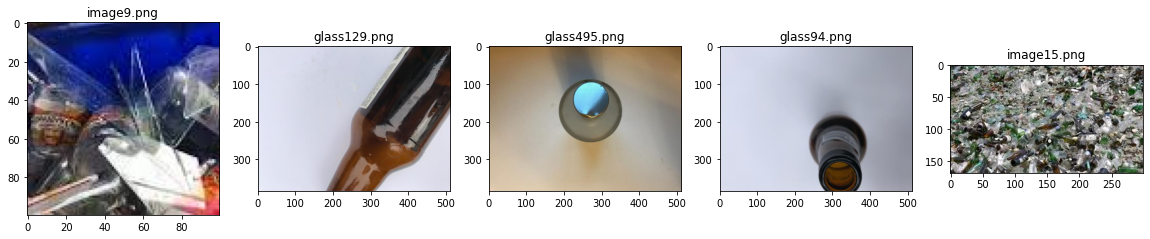

In [6]:
random.seed(10)
plt.figure(figsize=(20,20))

glass_folder = "/content/drive/MyDrive/Awareness of Waste Recycling/glass"
for i in range(5):
    file = random.choice(os.listdir(glass_folder))
    image_path= os.path.join(glass_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

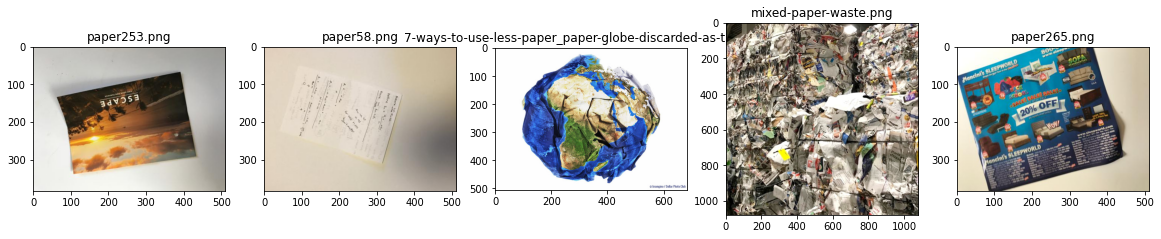

In [7]:
random.seed(10)
plt.figure(figsize=(20,20))

paper_folder = "/content/drive/MyDrive/Awareness of Waste Recycling/paper"
for i in range(5):
    file = random.choice(os.listdir(paper_folder))
    image_path= os.path.join(paper_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

In [8]:
transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(base_path, transform = transformations)

In [9]:
random_seed = 42
torch.manual_seed(random_seed)

In [10]:
train_ds, val_ds, test_ds = random_split(dataset, [5520,1250,835])
len(train_ds), len(val_ds), len(test_ds)

(5520, 1250, 835)

Text(0, 0.5, 'population')

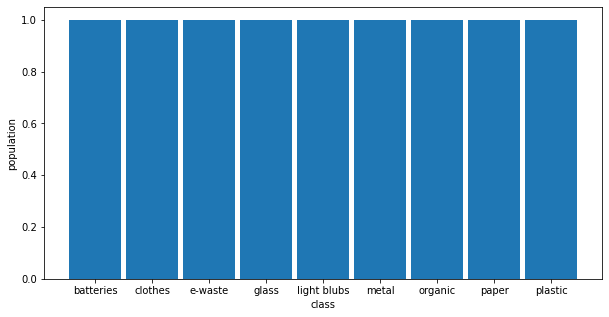

In [11]:
plt.subplots(figsize =(10,5))
plt.hist(dataset.classes, bins=np.arange(10)-0.5, rwidth=0.9)
plt.xlabel('class')
plt.ylabel('population')

In [12]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

In [13]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers = 4, pin_memory = True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [15]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
device = get_default_device()
device

device(type='cuda')

In [18]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [19]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [20]:
model = to_device(ResNet(), device)

In [21]:
evaluate(model, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.12715992331504822, 'val_loss': 2.1946732997894287}

In [22]:
num_epochs = 8
opt_func = torch.optim.Adam
lr = 5.5e-5

In [23]:
history_adam = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1: train_loss: 1.7149, val_loss: 1.5273, val_acc: 0.8565
Epoch 2: train_loss: 1.4869, val_loss: 1.4974, val_acc: 0.8731
Epoch 3: train_loss: 1.4299, val_loss: 1.4792, val_acc: 0.8926
Epoch 4: train_loss: 1.4125, val_loss: 1.4921, val_acc: 0.8778
Epoch 5: train_loss: 1.4010, val_loss: 1.4851, val_acc: 0.8716
Epoch 6: train_loss: 1.3929, val_loss: 1.4723, val_acc: 0.8981
Epoch 7: train_loss: 1.3873, val_loss: 1.4768, val_acc: 0.8853
Epoch 8: train_loss: 1.3872, val_loss: 1.4727, val_acc: 0.8910


In [24]:
opt_func = torch.optim.Adamax

history_adamax = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1: train_loss: 1.3829, val_loss: 1.4600, val_acc: 0.9090
Epoch 2: train_loss: 1.3792, val_loss: 1.4619, val_acc: 0.9090
Epoch 3: train_loss: 1.3794, val_loss: 1.4608, val_acc: 0.9144
Epoch 4: train_loss: 1.3780, val_loss: 1.4627, val_acc: 0.9051
Epoch 5: train_loss: 1.3778, val_loss: 1.4606, val_acc: 0.9082
Epoch 6: train_loss: 1.3768, val_loss: 1.4594, val_acc: 0.9136
Epoch 7: train_loss: 1.3765, val_loss: 1.4627, val_acc: 0.9131
Epoch 8: train_loss: 1.3760, val_loss: 1.4591, val_acc: 0.9098


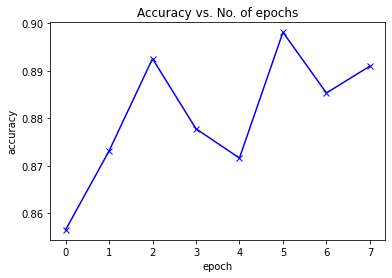

In [25]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history_adam]
    plt.plot(accuracies, '-bx',label = "Adam")
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

plot_accuracies(history_adam)

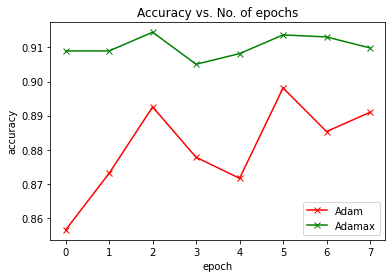

In [26]:
def plot_comparisons(history1, history2):
    accuracies1 = [x['val_acc'] for x in history_adam]
    accuracies2 = [x['val_acc'] for x in history_adamax]
    plt.plot(accuracies1, '-rx', label="Adam")
    plt.plot(accuracies2, '-gx', label="Adamax")
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.title('Accuracy vs. No. of epochs');

plot_comparisons(history_adam, history_adamax)

Adam Losses


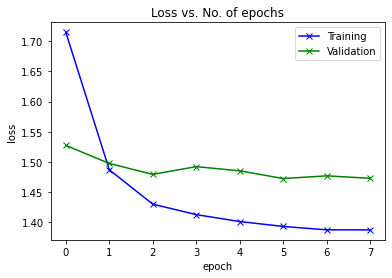

In [27]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-gx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

print("Adam Losses")
plot_losses(history_adam)

Adamax Losses


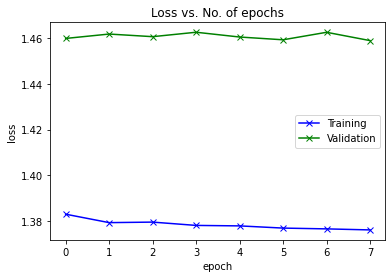

In [28]:
print("Adamax Losses")
plot_losses(history_adamax)

In [29]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: paper , Predicted: paper


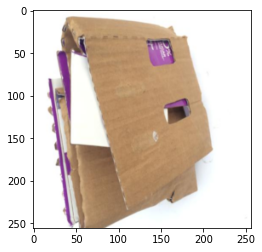

In [30]:
img, label = test_ds[42]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: plastic , Predicted: plastic


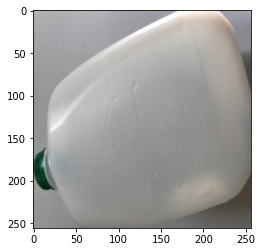

In [31]:
img, label = test_ds[79]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: glass , Predicted: glass


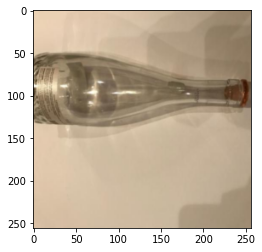

In [32]:
img, label = test_ds[200]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: organic , Predicted: organic


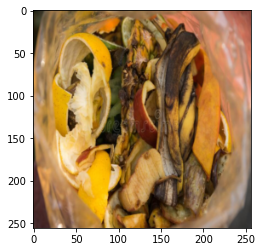

In [33]:
img, label = test_ds[500]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: organic , Predicted: organic


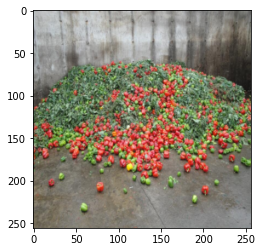

In [34]:
img, label = test_ds[30]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: paper , Predicted: paper


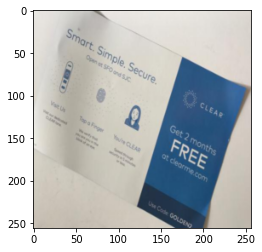

In [35]:
img, label = test_ds[180]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: paper , Predicted: paper


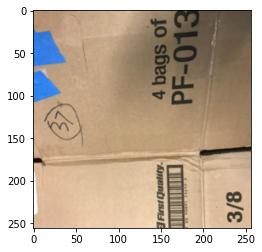

In [36]:
img, label = test_ds[540]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: clothes , Predicted: clothes


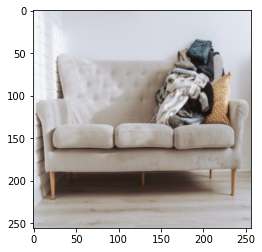

In [37]:
img, label = test_ds[309]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: organic , Predicted: organic


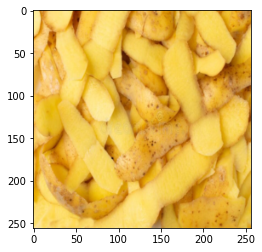

In [38]:
img, label = test_ds[310]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: metal , Predicted: metal


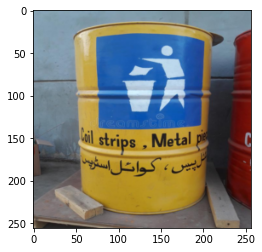

In [39]:
img, label = test_ds[240]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: paper , Predicted: paper


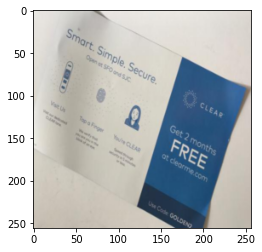

In [40]:
img, label = test_ds[180]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [41]:
torch.save(model.state_dict(), "Classify_Waste")